## <center> **Project 3: Booking reviews on Kaggle**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from afinn import Afinn
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

import geocoder
import re
import requests
from bs4 import BeautifulSoup as bs 


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif


from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor


import category_encoders as ce



In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!python -m pip freeze > requirements.txt

# 1. Загрузка данных и предварительный анализ

In [5]:
# Подгрузим наши данные из соревнования
#DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
submission = pd.read_csv('data/submission.csv') # датасет для сабмита

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# Признаки
- `hotel_address` - адрес отеля
- `review_date` - дата, когда рецензент разместил соответствующий отзыв.
- `average_score` - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- `hotel_name` - название отеля
- `reviewer_nationality` - национальность рецензента
- `negative_review` - отрицательный отзыв, который рецензент дал отелю.
- `review_total_negative_word_counts` - общее количество слов в отрицательном отзыв
- `positive_review` - положительный отзыв, который рецензент дал отелю
- `review_total_positive_word_counts` - общее количество слов в положительном отзыве
- `reviewer_score` - оценка, которую рецензент поставил отелю на основе своего опыта
- `total_number_of_reviews_reviewer_has_given` - количество отзывов, которые рецензенты дали в прошлом
- `total_number_of_reviews` - общее количество действительных отзывов об отеле
- `tags` - теги, которые рецензент дал отелю.
- `days_since_review` - продолжительность между датой проверки и датой очистки
- `additional_number_of_scoring` - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- `lat` - широта отеля
- `lng` - долгота отеля

# 2. EDA

In [9]:
# Для удобства дальнейших преобразований объеденим тестовый и тренировочный датасет в один
df_train['sample'] = 1 # Помечаем тренировочный датасет как 1, что-бы не потерять
df_test['sample'] = 0 # Помечаем тестовый датасет как 0
df_test['reviewer_score'] = 0 # Ставим значение целевой переменной 0 (по причине отсутствия в этом датасете) 

data = df_test.append(df_train, sort=False).reset_index(drop=True) # Объеденение
data.shape

C:\Users\German\AppData\Local\Temp\ipykernel_19224\1614937119.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # Объеденение


(515738, 18)

In [10]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


# 2.1 Общий анализ

In [11]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [12]:
# уникальные значения в признаках
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

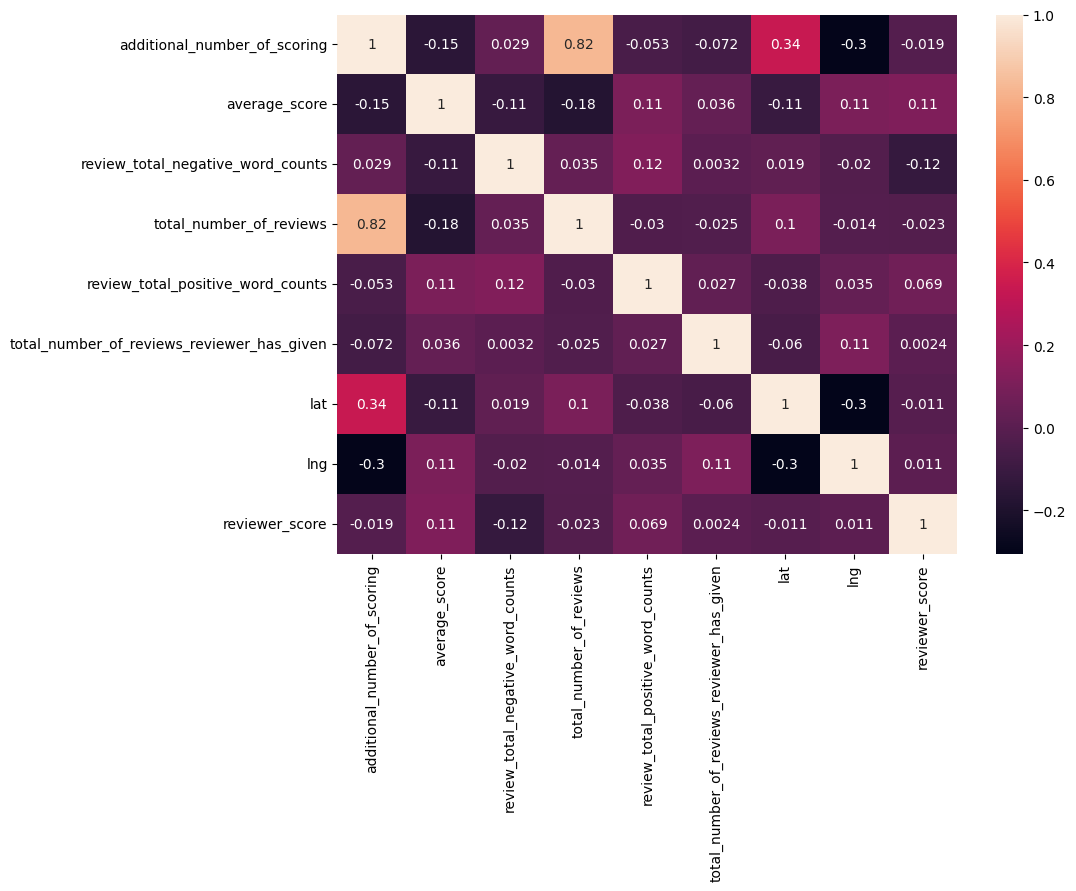

In [13]:
# проверяем корреляцию признаков
plt.rcParams['figure.figsize'] = (10,7)
sns.heatmap(data.drop(['sample'],axis=1).corr(),annot=True);

Имеется весьма сильная корреляция между признаками 'total_number_of_reviews' и 'additional_number_of_scoring', следовательно один из признаков можно будет удалить. Остальные признаки не сильно коррелируют друг с другом.

In [14]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В датасете присутствуют пропуски в двух признаках - геограрфических координатах `lat` и `lng`. Заполнять их медианой, средним значением и тд не подойдет для такого рода признаков, так что решение будем искать далее при проектировании новых признаков.

# 2.3 Создание и преобразование признаков

In [15]:
# Засосем данные по индексу Джини
gdp = pd.read_excel('https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel',header=3)

# Отбросим лишние данные и преобразуем в словарь
cols_to_drop = list(gdp.columns)
cols_to_drop.remove('2020')
gdp.index = gdp['Country Name']
gdp.drop(cols_to_drop,axis=1,inplace=True)
gdp = gdp.to_dict(orient='index')

In [16]:
# Найдем данные об индексе Джини и населению стран
# url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
# page = requests.get(url)

# soup = bs(page.content, 'html.parser')
# tbl = soup.find("table")

gini_index = pd.read_csv('data/data.csv')

gini_index.head()

,place,pop2023,growthRate,area,country,cca3,cca2,ccn3,region,subregion,landAreaKm,density,densityMi,Rank,giniWB,yearWB,giniCIA,yearCIA,rank
0,710,60414495.0,0.00869,1221037.0,South Africa,ZAF,ZA,710,Africa,"Southern Africa, Sub-Saharan Africa",1213090.0,49.8022,128.9876,24,63.0,2014.0,63.0,2014.0,1
1,516,2604172.0,0.01448,825615.0,Namibia,NAM,NaN,516,Africa,"Southern Africa, Sub-Saharan Africa",823290.0,3.1631,8.1925,145,59.1,2015.0,59.1,2015.0,2
2,740,623236.0,0.00841,163820.0,Suriname,SUR,SR,740,South America,"South America, Latin America",156000.0,3.9951,10.3473,170,57.9,1999.0,NaN,NaN,3
3,894,20569737.0,0.02758,752612.0,Zambia,ZMB,ZM,894,Africa,"Eastern Africa, Sub-Saharan Africa",743390.0,27.6702,71.6658,63,57.1,2015.0,57.1,2015.0,4
4,678,231856.0,0.01969,964.0,Sao Tome and Principe,STP,ST,678,Africa,"Middle Africa, Sub-Saharan Africa",960.0,241.5167,625.5282,187,56.3,2017.0,56.3,2017.0,5


In [17]:
# дропнем ненужные столбцы
useful_cols = ['country','giniWB','yearWB','giniCIA','yearCIA','pop2023']
gini_index = gini_index.drop([col for col in gini_index.columns if col not in useful_cols], axis=1)
gini_index

,pop2023,country,giniWB,yearWB,giniCIA,yearCIA
0,60414495.0,South Africa,63.0,2014.0,63.0,2014.0
1,2604172.0,Namibia,59.1,2015.0,59.1,2015.0
2,623236.0,Suriname,57.9,1999.0,NaN,NaN
3,20569737.0,Zambia,57.1,2015.0,57.1,2015.0
4,231856.0,Sao Tome and Principe,56.3,2017.0,56.3,2017.0
...,...,...,...,...,...,...
172,704149.0,Macau,NaN,NaN,35.0,2013.0
173,111802.0,Jersey,NaN,NaN,0.3,2014.0
174,56643.0,Greenland,NaN,NaN,33.9,2015.0
175,53270.0,Faroe Islands,NaN,NaN,22.7,2013.0


## 2.3.1. Извлечение информации из текстовых признаков

In [18]:
# можно "вытащить" название города и страны из адреса отеля
# для начала можно создать список со всеми отелями и их координатами
hotel_coor = data[['hotel_address','lat','lng']].groupby(by=['hotel_address'],as_index=True).mean()

# определим координаты отелей
for i in hotel_coor[hotel_coor['lat'].isnull()].index:
    g = geocoder.arcgis(i)
    hotel_coor.at[i,'lat'] = g.latlng[0]
    hotel_coor.at[i,'lng'] = g.latlng[1]
    
# разберем адрес на страну и город
hotel_coor['country'] = ''
hotel_coor['address'] = hotel_coor.index
hotel_coor['country'] = hotel_coor['address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))
latlng_dict = hotel_coor.to_dict(orient='index')

# сети отелей
data['hotel_net'] = data['hotel_name'].apply(
    lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x)[0] \
        if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x) is not None) \
    else 'Not_in_net'
    )

# определим страну и город
data['country'] = ''
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

# Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран с отелем
# data['hc_gini'] = data['country'].apply(lambda x: gini_index[x]['giniWB'])
# data['hc_population'] = data['country'].apply(lambda x: gini_index[x]['pop2023'])
# data['hc_gdp'] = data['country'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)  # выдает ошибку: KeyError 'Italy', может потом исправлю

# первая попытка
def find_city_country(address):
    address = address.replace('United Kingdom','UK') # едиственная страна состоящая из двух слов
    adr_list = [word for word in address.split(' ') if word.isalpha()] # слова не включающие цифры
    return (adr_list[len(adr_list)-2], adr_list[len(adr_list)-1])

data['city'] = data['hotel_address'].apply(lambda x: find_city_country(x)[0]) 
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

В данных оставляю только город, так как в наших данных есть прямое соответствие между городом и страной. Информация о городе так-же поможет заполнить пропуски в географических координатах.

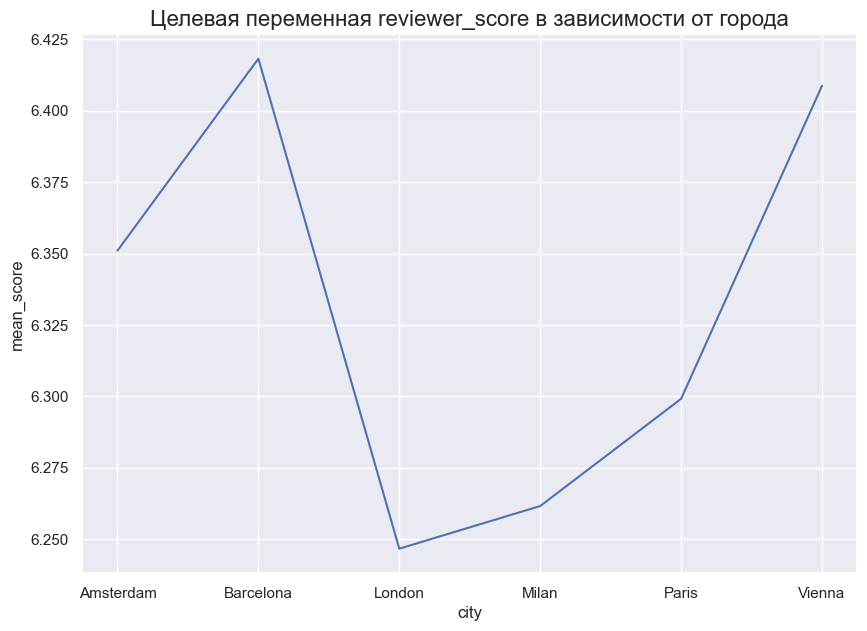

In [19]:
# проверим зависимость рейтинга от города
grouped = data.groupby('city', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='city', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от города', fontdict={'fontsize':16});

Как видим на графике, средние оценки посетителей отеля разнятся  в зависимости от города. Самые высокие средние оценки наблюдаются в Барселоне (около 6.4), и самые низкие в Лондоне (около 6.2), что не является существенной разницей на первый взгляд, всего 2 десятых. 

## 2.3.2 Работа с датами

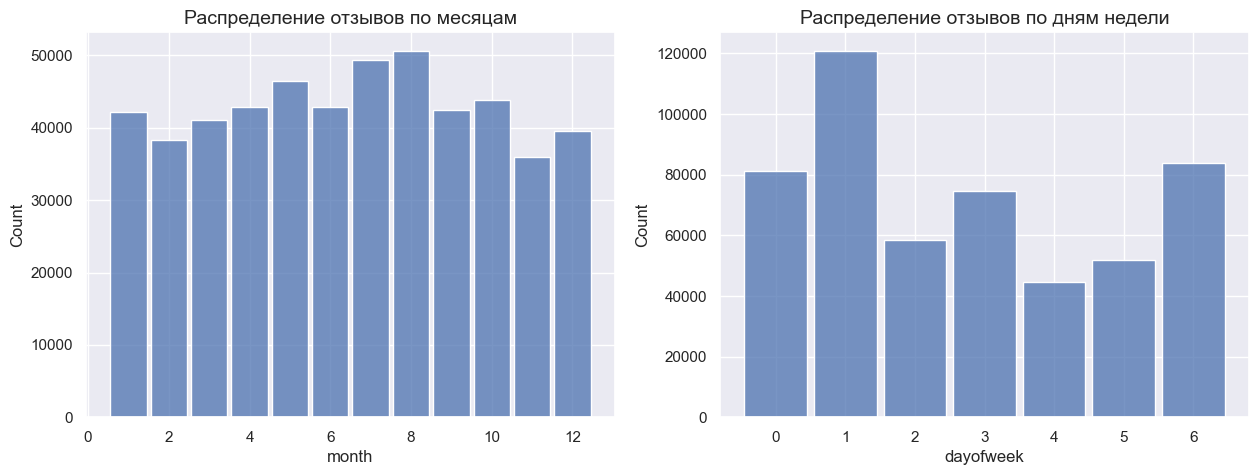

In [20]:
# Из признака с датами можно выделить год, месяц и день недели

data['review_date'] = pd.to_datetime(data['review_date']) # преобразуем формат в дату

data['day'] = data['review_date'].dt.day
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month # выделим месяц
data['dayofweek'] = data['review_date'].dt.dayofweek # и день недели

# создаём новый признак 'год-месяц'
data['year_month'] = data['review_date'].dt.to_period("M")

# Удаляем review_date
data.drop('review_date', axis = 1, inplace=True)
# кодируем признак 'year_month'
data['year_month'] = data['year_month'].astype('category')
period_te = ce.TargetEncoder(
    min_samples_leaf=20, smoothing=10).fit_transform(
        data['year_month'], data['reviewer_score']
).rename(columns={'year_month':'YM_te'}, inplace=True)
data = pd.concat([data,period_te], axis=1)
  
# Графики распределения отзывов
sns.set_theme()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='month', discrete=True, shrink=.9, ax=ax[0])
sns.histplot(data=data, x='dayofweek', discrete=True, shrink=.9, ax=ax[1])
ax[0].set_title('Распределение отзывов по месяцам', fontdict={'size': 14})
ax[1].set_title('Распределение отзывов по дням недели', fontdict={'size': 14});

Наибольшее кол-во отзывов, как и ожидалось, приходиться на летние месяцы. Пиковый месяц - август, далее июль и на третьем месте май.

По графику распределения отзывов по дням недели видим, что большее кол-во отзывов приходится на вторник и на воскресенье (1,6).

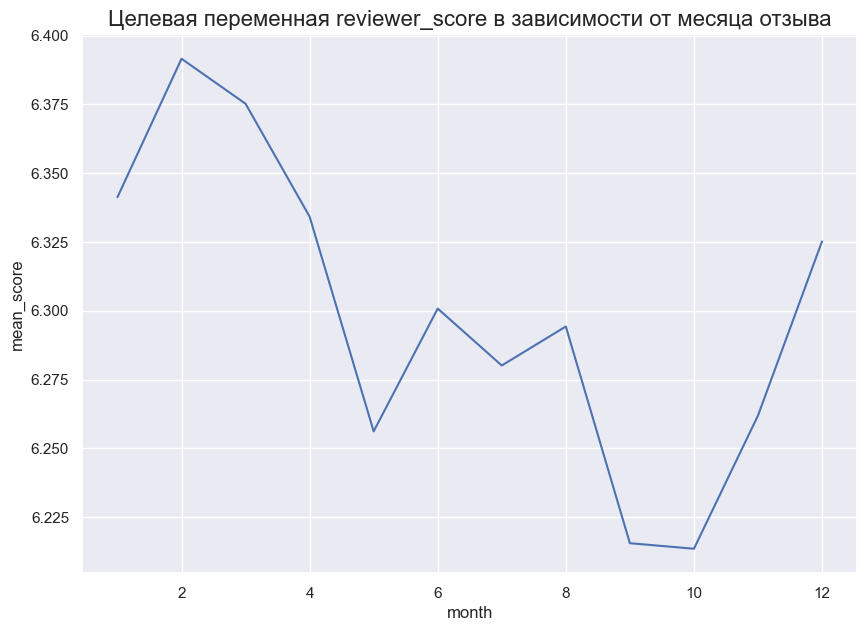

In [21]:
# Зависимость средних оценок от месяца выставления оценки
grouped = data.groupby('month', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='month', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от месяца отзыва', fontdict={'fontsize':16});

Самые высокие оценки наблюдаются в зимние месяцы (6.35 - 6.4), к весне наблюдается спад (6.25), летом небольшой подъем (6.3), к осени оценки вновь падают и доходят до отметки в 6.2 и ближе к зиме снова поднимаются.

In [34]:
# Признак время года
# def season(mth):
#     if mth in range (3,6):
#         return 'spring'
#     elif mth in range (6,9):
#         return 'summer'
#     elif mth in range (9,12):
#         return 'autumn'
#     else:
#         return 'winter'

# data['review_season'] = data['review_month'].apply(season)

# data['review_season'].value_counts(normalize=True)   
# этот шаг оказался ненужным, лишь добавляет времени на вычисление, а толку ноль, увы

summer    0.277052
spring    0.253002
autumn    0.237022
winter    0.232924
Name: review_season, dtype: float64

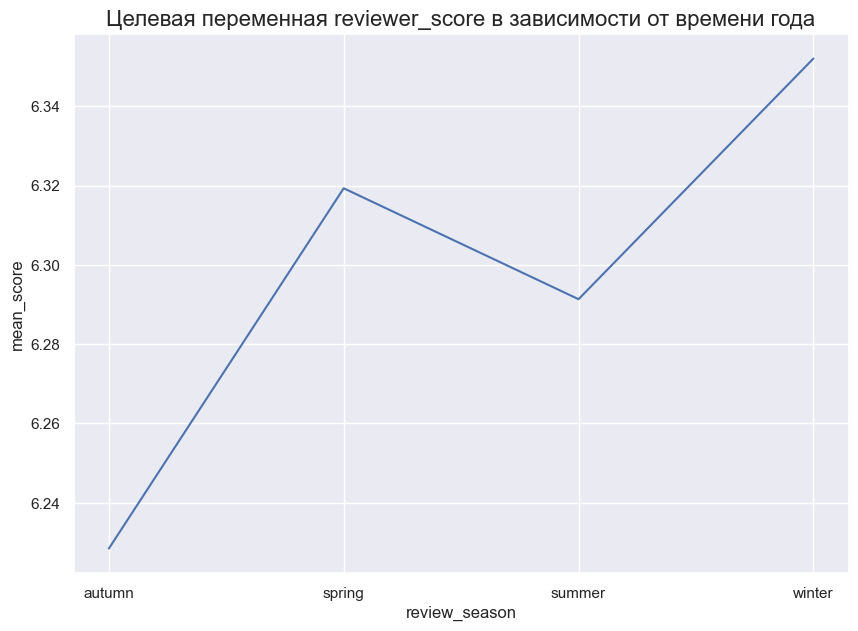

In [35]:
# Зависимость средних оценок от времени года
# grouped = data.groupby('review_season', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

# sns.set_theme()
# fig = sns.lineplot(data=grouped, x='review_season', y='mean_score', markers=True, dashes=False)
# fig.set_title('Целевая переменная reviewer_score в зависимости от времени года', fontdict={'fontsize':16});

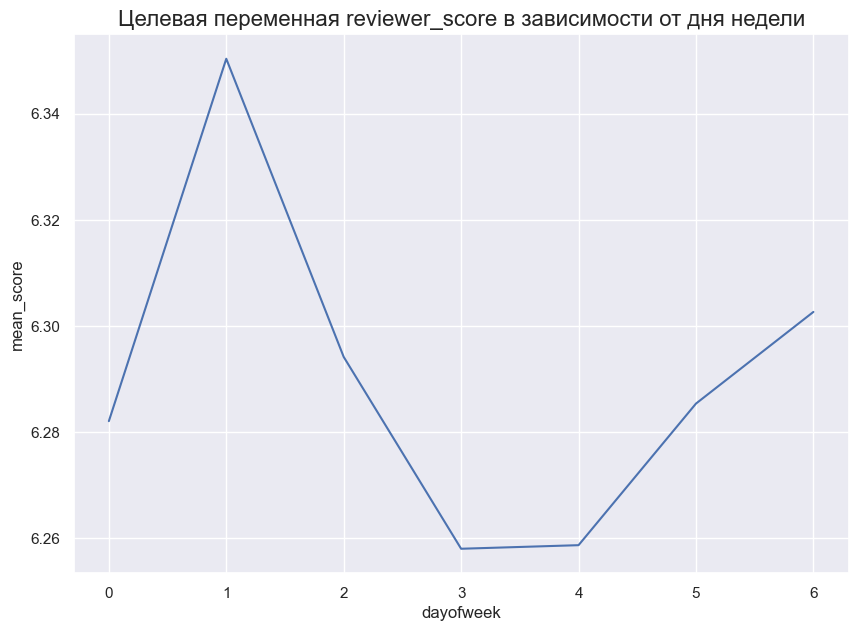

In [22]:
# Зависимость средних оценок от дня недели выставления оценки

grouped = data.groupby('dayofweek', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

sns.set_theme()
fig = sns.lineplot(data=grouped, x='dayofweek', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от дня недели', fontdict={'fontsize':16});

Наивысшая средняя оценка приходиться на вторник, а самые низкие оценки на четверг и пятницу.

In [23]:
# Национальности путешественников
data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

Как мы видим, обывателей из Великобритании подавляющее большинство, это может быть связано с тем, что самым популярным городом (по кол-ву отелей в наших данных) является Лондон. После Великобритании идет США, Австралия и Ирландия, далее национальности мало отличаются по кол-ву отзывов. 

In [24]:
# Поправим представление данных о национальности, оно имеет пробелы в конце и начале
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])

In [25]:
# Поправим данные об Америке
us_list = ['Jersey','United States of America']
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United States' if x in us_list else x)

In [26]:
# Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран ревьюера
data['rc_gini'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['giniWB'] if gini_index.get(x) is not None else 0)
data['rc_population'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['pop2023'] if gini_index.get(x) is not None else 0)
data['rc_gdp'] = data['reviewer_nationality'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)

In [27]:
# Дозапоним индексы Джини медианным значением
data['rc_gini'].fillna(data['rc_gini'].median(),inplace=True)
data['rc_gdp'].fillna(data['rc_gdp'].median(),inplace=True)

In [28]:
# Приведем столбец days_since_review к числовому формату
data['days_since_review'] = data['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
data['days_since_review'] = data['days_since_review'].astype('int')

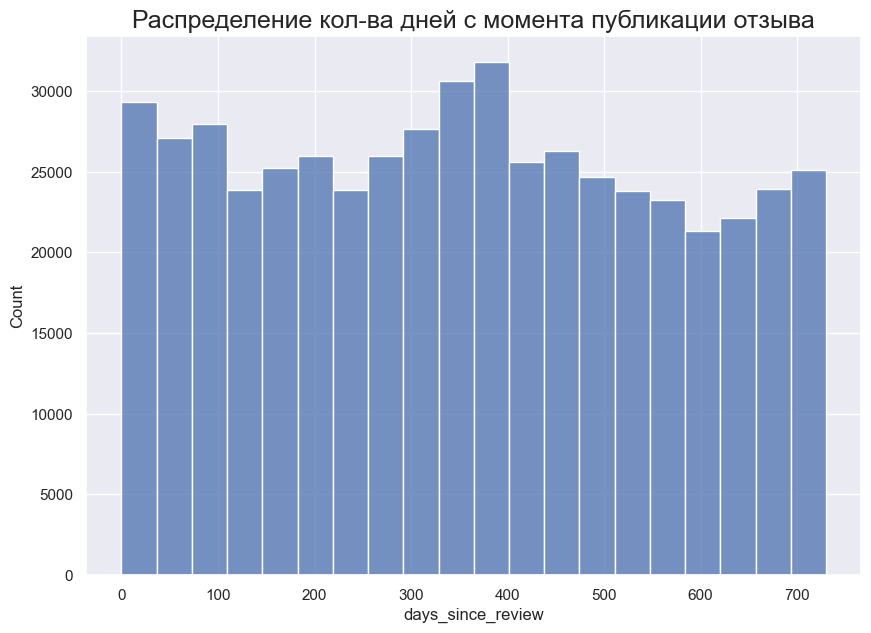

In [29]:
# График распределения
fig = sns.histplot(data=data, x='days_since_review', bins=20)
fig.set_title('Распределение кол-ва дней с момента публикации отзыва', fontdict={'size': 18});

В нашем файле много свежих отзывов (дней с момента публикации чуть больше 0) и отзывов со сроком давности около года (300-400 дней)В нашем файле много свежих отзывов (дней с момента публикации чуть больше 0) и отзывов со сроком давности около года (300-400 дней).

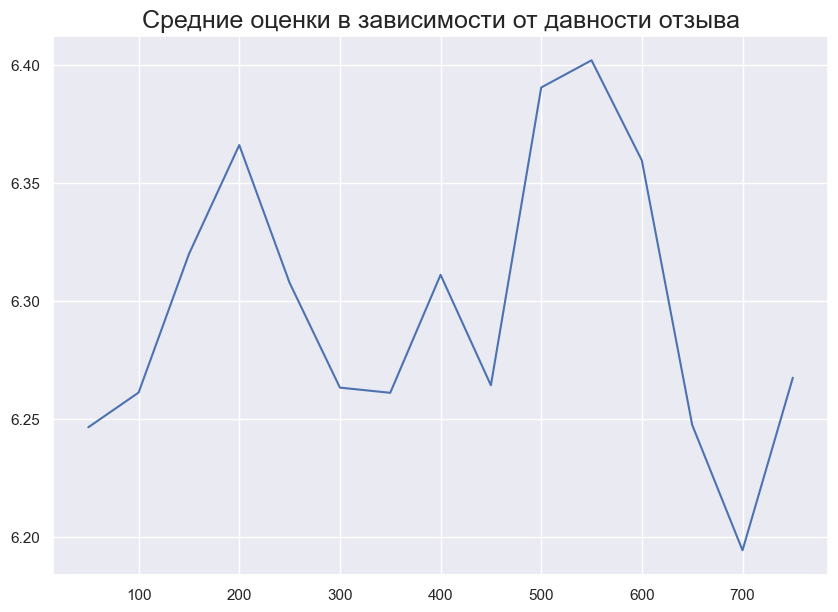

In [32]:
# Проанализируем оценки в зависимости от давности отзыва
days_list=[]
marks = []

for i in range(0, 800, 50):
    days_list.append(i)
    mark = data[(data['days_since_review']<i)&(data['days_since_review']>i-50)]['reviewer_score'].mean()
    marks.append(mark)
    
fig = sns.lineplot(x=days_list, y=marks)
fig.set_title('Средние оценки в зависимости от давности отзыва', fontdict={'size': 18});

Есть небольшие отличия в средних оценках, и виден небольной скачек в отзывах оставленых 500-600 дней назад. Однако трудно сказать, есть ли одназначная зависимость от давности отзыва и насколько он высокий. Возможно здесь так же отражается влияние времен года.

In [33]:
# Разберем тэги
data['tags'] = data['tags'].apply(lambda x: x.lower())
data['tags_list'] = data['tags'].apply(lambda x: re.findall(r'\' ([\w ]+) \'', x))

tags_list = []
for i in data.index:
    for val in data['tags_list'][i]:
        tags_list.append(val)

In [34]:
import collections
sent_analyzer = SentimentIntensityAnalyzer()
tags_cnt = collections.Counter(tags_list)
top_tags_set = set([key for key, _ in tags_cnt.most_common(10)])

data['tags'] = data['tags_list'].apply(lambda x: '|'.join(sorted(list(top_tags_set.intersection(set(x))))))

## Рассмотрим отзывы

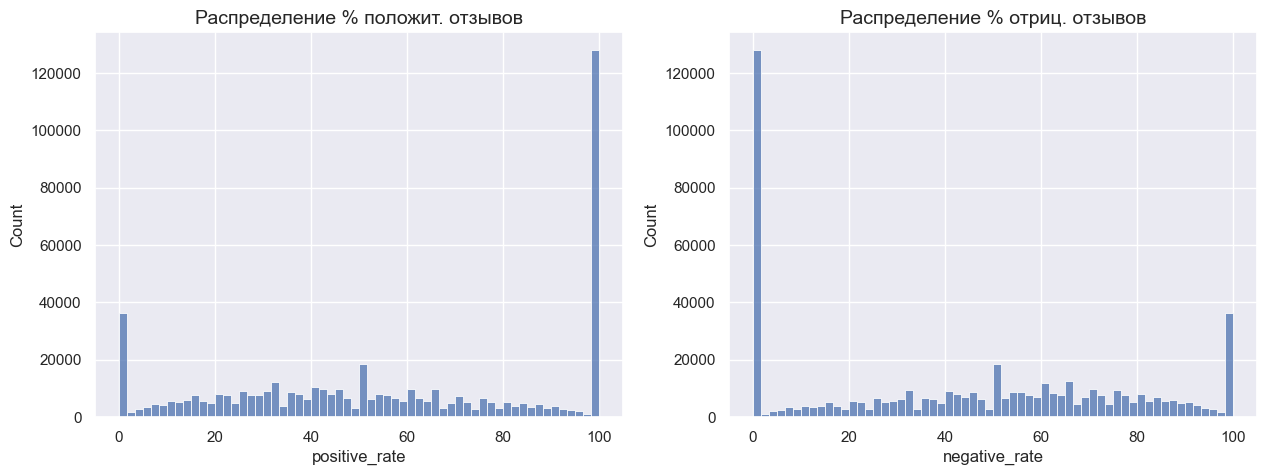

In [35]:
# Всего слов в отзывах каждого пользователя
data['total_words'] = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']
# Доли положительных и отрицательных частей
data['positive_rate'] = data['review_total_positive_word_counts'] / data['total_words'] * 100
data['negative_rate'] = data['review_total_negative_word_counts'] / data['total_words'] * 100

# Графики распределения отзывов
sns.set_theme()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='positive_rate', ax=ax[0])
sns.histplot(data=data, x='negative_rate', ax=ax[1])
ax[0].set_title('Распределение % положит. отзывов', fontdict={'size': 14})
ax[1].set_title('Распределение % отриц. отзывов', fontdict={'size': 14});

In [36]:
data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

In [37]:
# Разберем негативные комменты
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower())
data['negative_rev_words_list'] = data['negative_review'].apply(lambda x: x.split(' '))
negative_rev_words_list = []
for i in data.index:
    for val in data['negative_rev_words_list'][i]:
        negative_rev_words_list.append(val)
        
negative_rev_words_cnt = collections.Counter(negative_rev_words_list)
top_negative_rev_words_set = set([key for key, _ in negative_rev_words_cnt.most_common(5)])

data['negative_rev_words_list'] = data['negative_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_negative_rev_words_set.intersection(set(x))))))

In [38]:
# Разберем позитивные комменты
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower())
data['positive_rev_words_list'] = data['positive_review'].apply(lambda x: x.split(' '))
positive_rev_words_list = []
for i in data.index:
    for val in data['positive_rev_words_list'][i]:
        positive_rev_words_list.append(val)  
              
positive_rev_words_cnt = collections.Counter(positive_rev_words_list)
top_positive_rev_words_set = set([key for key, _ in positive_rev_words_cnt.most_common(5)])
    
data['positive_rev_words_list'] = data['positive_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_positive_rev_words_set.intersection(set(x))))))

In [39]:
# Разберемся со столбцом национальности ревьюера
rnat_list = []

for i in data.index:
    rnat_list.append(data['reviewer_nationality'][i]) 
 
from sklearn.preprocessing import OrdinalEncoder      
rnat_cnt = collections.Counter(rnat_list)
top_rnat_set = set([key for key, _ in rnat_cnt.most_common(20)]) # changed to 20 (form 5)
    
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_rnat_set else 'other')    
    
to_ordenc_list = ['reviewer_nationality','country','positive_rev_words_list','negative_rev_words_list','tags','hotel_net']
enc = OrdinalEncoder()
enc.fit(data[to_ordenc_list])
data[to_ordenc_list] = enc.transform(data[to_ordenc_list])
data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)

In [40]:
# Выведем процентное содержание позитивных и негативных слов
data['positive_rate'] = 100 * data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['negative_rate'] = 100 * data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['#_pos_words'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['#_neg_words'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['pos_rev_rate'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews']
data['neg_rev_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
data['positive_rate'].fillna(0,inplace=True)
data['negative_rate'].fillna(0,inplace=True)
data['add_pos_rate'] = data['review_total_positive_word_counts'] / data['additional_number_of_scoring']
data['add_neg_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
data['review_rate'] = data['total_number_of_reviews_reviewer_has_given'] / data['total_number_of_reviews']

In [41]:
# Разберём положительные отзывы, выясним за что больше всего посетителей хвалят отели
positive_reviews = data['positive_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=positive_reviews)
df_rev.to_csv('data/positive_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Bed, location, staff, breakfast, clean, room - посетители часто отмечают это в положительных отзывах
# Создадим бинарные признаки. 1, если этот момент отмечен в отзыве, 0 - не отмечен

data['positive_bed'] = data['positive_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['positive_location'] = data['positive_review'].apply(lambda x: 1 if 'location' in x.lower() else 0)
data['positive_staff'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['positive_breakfast'] = data['positive_review'].apply(lambda x: 1 if 'breakfast' in x.lower() else 0)
data['positive_room'] = data['positive_review'].apply(lambda x: 1 if 'room' in x.lower() else 0)

In [42]:
# Аналогично поработаем с негативными отзывами
negative_reviews = data['negative_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=negative_reviews)
df_rev.to_csv('data/negative_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Noise, bed, breakfast, bath or shower, clean, dirt, internet or wi fi or wifi, room, staff or reception, charge or expensive or price or cost, tired or old, 
# Найдём наиболее часто встречающиеся слова в тексте и создадим соответствующие признаки:
# 1, если путешественник жаловался на эту вещь, 0 - если нет

data['negative_meal'] = data['negative_review'].apply(lambda x: 1 if 'breakfast' in x.lower()
                                                      or 'meal' in x.lower() or 'dinner' in x.lower() else 0)
data['negative_bed'] = data['negative_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['negative_bath'] = data['negative_review'].apply(lambda x: 1 if 'bath' in x.lower() or 'shower' in x.lower() else 0)
data['negative_wifi'] = data['negative_review'].apply(lambda x: 1 if 'internet' in x.lower() or 'wifi' in x.lower()
                                                      or 'wi fi' in x.lower() or 'wi-fi' in x.lower() else 0)
data['negative_staff'] = data['negative_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['negative_price'] = data['negative_review'].apply(lambda x: 1 if 'charge' in x.lower() or 'price' in x.lower()
                                                       or 'expensive' in x.lower() or 'cost' in x.lower()
                                                       or 'euro' in x.lower() or 'pound' in x.lower()
                                                       or 'pricey' in x.lower() or 'pricy' in x.lower() else 0)
data['negative_old'] = data['negative_review'].apply(lambda x: 1 if 'old' in x.lower() or 'tired' in x.lower()
                                                     or 'renovation' in x.lower() else 0)
data['negative_location'] = data['negative_review'].apply(lambda x: 1 if 'far away' in x.lower() or 'bit of walk' in x.lower()
                                                          or 'walk from' in x.lower() or 'out of the way' in x.lower()
                                                          or 'far from' in x.lower() else 0)
data['negative_clean'] = data['negative_review'].apply(lambda x: 1 if 'clean' in x.lower() or 'dirt' in x.lower() else 0)

In [54]:
# Проанализируем теги
# tags = data['tags'].value_counts(normalize=True)
# df_tags = pd.DataFrame(data=tags)
# df_tags.to_csv('data/tags.csv') # сохраним, чтобы просмотреть все теги

# # Цель поездки
# def trip_purp(tags_text): 
#     if 'Business' in tags_text:
#         return 'Business'
#     elif 'Leisure' in tags_text:
#         return 'Leisure'
#     else:
#         return 'Unknown'
    
# # Состав путешественников
# def who_travels(tags_text):
#     if 'Solo' in tags_text:
#         return 'Solo'
#     elif 'Couple' in tags_text:
#         return 'Couple'
#     elif 'Family' in tags_text:
#         return 'Family'
#     elif 'friends' in tags_text:
#         return 'Friends'
#     elif 'pet' in tags_text:
#         return 'With a pet'
#     elif 'Group' in tags_text:
#         return 'Group'
#     else:
#         return 'Other'
    
# # Длительность поездки
# def trip_duration(tags_text):
#     days = tags_text.find('Stayed')
#     if days > 0:
#         return int(tags_text[days+6:days+9]) # если нашли такой тег, возвращаем следом идущее кол-во дней, максимум двузначное
#     return -1 # если не нашли нужный тег

# # создаем признаки
# data['trip_purpose'] = data['tags'].apply(trip_purp) 
# data['who_travels'] = data['tags'].apply(who_travels) 
# data['trip_duration'] = data['tags'].apply(trip_duration) 

Данный шаг был протестироан в тестовой версии, но к сожалению модель от этого предсказывать лучше не стала.

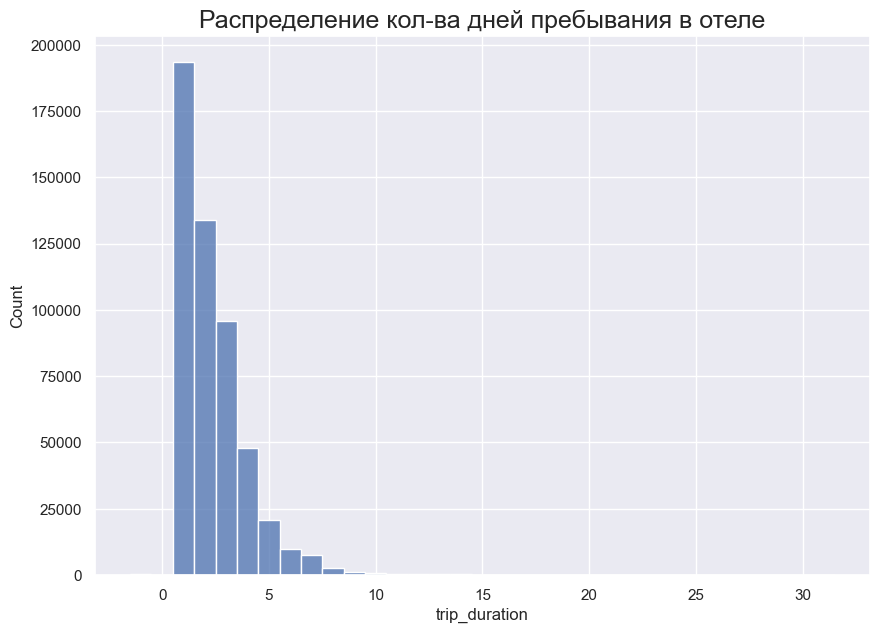

In [35]:
# График распределения
# fig = sns.histplot(data=data, x='trip_duration', discrete=True)
# fig.set_title('Распределение кол-ва дней пребывания в отеле', fontdict={'size': 18});

Как видим, большинство людей останавливаются в отеле только на один или несколько дней. Крайне малый процент соискателей останавливается в отеле больше чем на 5 дней.

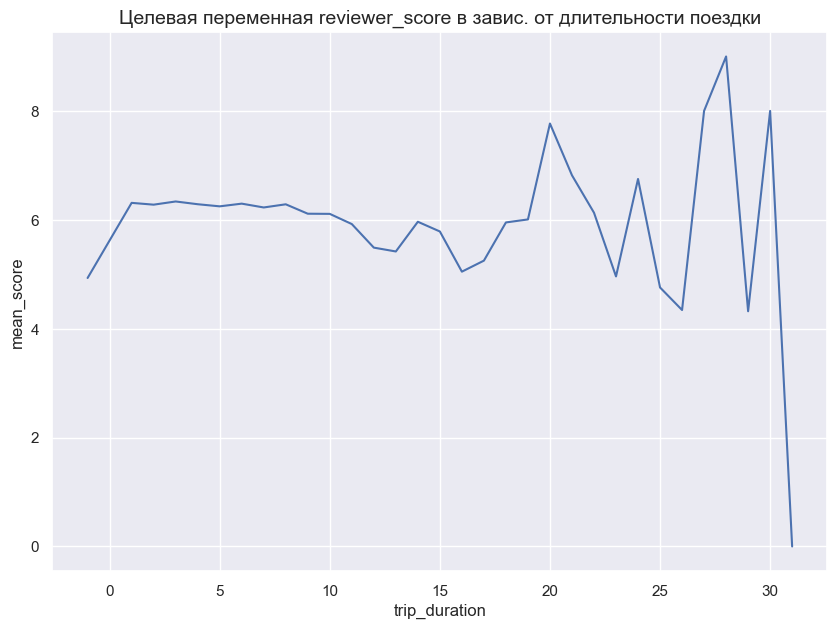

In [36]:
# Зависимость оценки от продолжительности путешествия
# grouped = data.groupby('trip_duration', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

# sns.set_theme()
# fig = sns.lineplot(data=grouped, x='trip_duration', y='mean_score', markers=True, dashes=False)
# fig.set_title('Целевая переменная reviewer_score в завис. от длительности поездки', fontdict={'fontsize':14});

Длительность поездки меньше 0 означает, что не был найден тег в данных. Как видим, разброс средних оценок с увеличением длительности поездки растет, и при этом график распределения показывает, что кол-во посетителей при этом снижается (это скорее всего и является причиной разброса). Попробуем изменить признак, создадим две группы - продолжительность поездки до 15 дей и свыше 15 дней.

## 2.3.3 Обрабоатем пропуски

Во второй версии я решил заполнить пропуски способом ниже, а далее можете понаблюдать за другим подходом, они в целом не сильно по эффективности отличаються, тем не менее оставлю оба.

In [43]:
# Заполним координаты в главном DataFrame'е
for i in data[data['lat'].isnull()].index:
    data.at[i,'lat'] = latlng_dict[data['hotel_address'][i]]['lat']
    data.at[i,'lng'] = latlng_dict[data['hotel_address'][i]]['lng']

А вот и первый вариант, тут заполняем пропуски исходя из признака city.

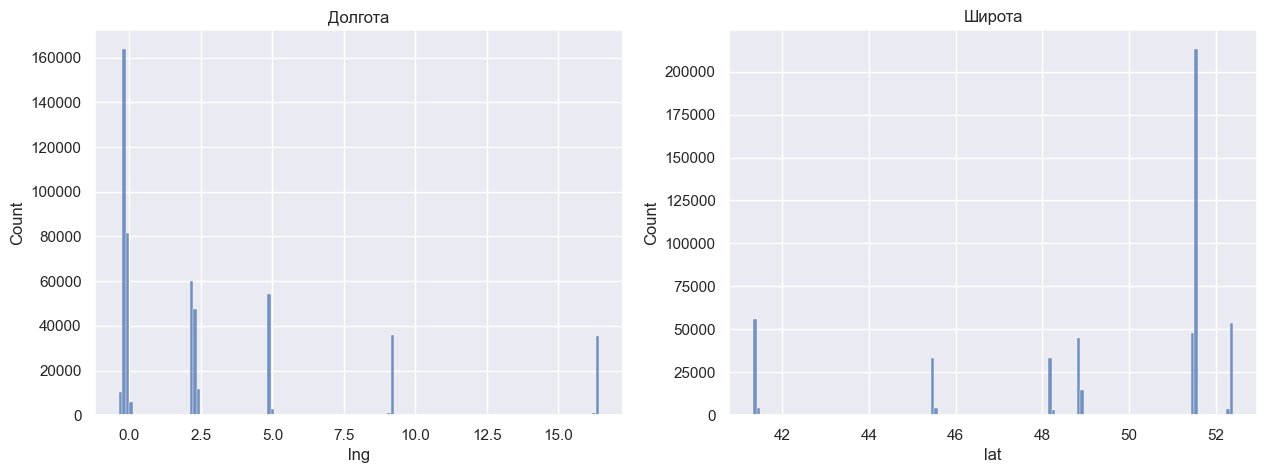

In [38]:
# Признаки с пропусками - долгота и широта - по идее можно заполнить на основании созданного признака city
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

# sns.histplot(x='lng', data=data, ax=ax[0])
# ax[0].set_title('Долгота')
# sns.histplot(x='lat', data=data, ax=ax[1])
# ax[1].set_title('Широта');

In [39]:
# Рассчитаем средние значения широты и долготы для каждого города
# data.groupby('city', as_index=False).agg(mean_lat=('lat', 'mean'), mean_lng=('lng', 'mean'))

,city,mean_lat,mean_lng
0,Amsterdam,52.362206,4.885409
1,Barcelona,41.389079,2.169147
2,London,51.510739,-0.138960
3,Milan,45.479617,9.191835
4,Paris,48.863715,2.326780
5,Vienna,48.203362,16.367234


In [40]:
# распределение пропусков по городам
# data[data['lat'].isnull()].groupby('city', as_index=False).agg(qty=('city', 'count'))

,city,qty
0,Barcelona,207
1,Paris,382
2,Vienna,2679


In [41]:
# Заполним пропуски средними значениями для каждого города
# data.loc[(data['city']=='Barcelona') & (data['lat'].isnull()), 'lat'] = 41.389079
# data.loc[(data['city']=='Barcelona') & (data['lng'].isnull()), 'lng'] = 2.169147

# data.loc[(data['city']=='Paris') & (data['lat'].isnull()), 'lat'] = 48.863715
# data.loc[(data['city']=='Paris') & (data['lng'].isnull()), 'lng'] = 2.326780

# data.loc[(data['city']=='Vienna') & (data['lat'].isnull()), 'lat'] = 48.203362
# data.loc[(data['city']=='Vienna') & (data['lng'].isnull()), 'lng'] = 16.367234

Проблему с пропусками то мы решили, однако такое явное соответсвие города и координат - это дублирование информации, так что возможно какие-то признаки придеться удалить. 

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   average_score                               515738 non-null  float64 
 3   hotel_name                                  515738 non-null  object  
 4   reviewer_nationality                        515738 non-null  float64 
 5   negative_review                             515738 non-null  object  
 6   review_total_negative_word_counts           515738 non-null  int64   
 7   total_number_of_reviews                     515738 non-null  int64   
 8   positive_review                             515738 non-null  object  
 9   review_total_positive_word_counts           515738 non-null

## 2.4 Вклад признаков в формирование целевой переменной

In [49]:
# Удаляем нечисловые признаки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('year_month', axis=1, inplace=True)

In [50]:
# Разделим обработанные данные

train_data = data[data['sample'] == 1]
test_data = data[data['sample'] == 0]

train_data.drop(['sample'],axis=1,inplace=True)
test_data.drop(['sample','reviewer_score'],axis=1,inplace=True)

C:\Users\German\AppData\Local\Temp\ipykernel_21432\2383553733.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['sample'],axis=1,inplace=True)
C:\Users\German\AppData\Local\Temp\ipykernel_21432\2383553733.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['sample','reviewer_score'],axis=1,inplace=True)


In [55]:
pd.set_option('display.max_columns', None)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 128935 to 515737
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   reviewer_nationality                        386803 non-null  float64
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   review_total_positive_word_counts           386803 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   tags                                        386803 non-null  float64
 8   days_since_review                           386803 non-null  int32  
 9   lat                                         386803 non-null  floa

In [73]:
# Непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given', 'days_since_review','lat', 'lng',
             'rc_gini', 'rc_population', 'rc_gdp', 'n_neg', 'n_neu', 'n_pos', 'n_compound', 
             'p_neg', 'p_neu', 'p_pos', 'p_compound','neg_len','pos_len','#_pos_words',
             '#_neg_words','review_rate','neg_rev_rate','pos_rev_rate','add_pos_rate','add_neg_rate']

# Категориальные признаки
cat_cols = ['reviewer_nationality', 'tags', 'country', 'negative_rev_words_list','positive_rev_words_list', 'year', 'month', 'day',
            'dayofweek', 'positive_bed', 'positive_location', 'positive_staff', 'positive_breakfast','positive_room',	
            'negative_meal','negative_bed','negative_bath','negative_wifi','negative_staff','negative_price','negative_old','negative_location','negative_clean']

In [75]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score']

<AxesSubplot: >

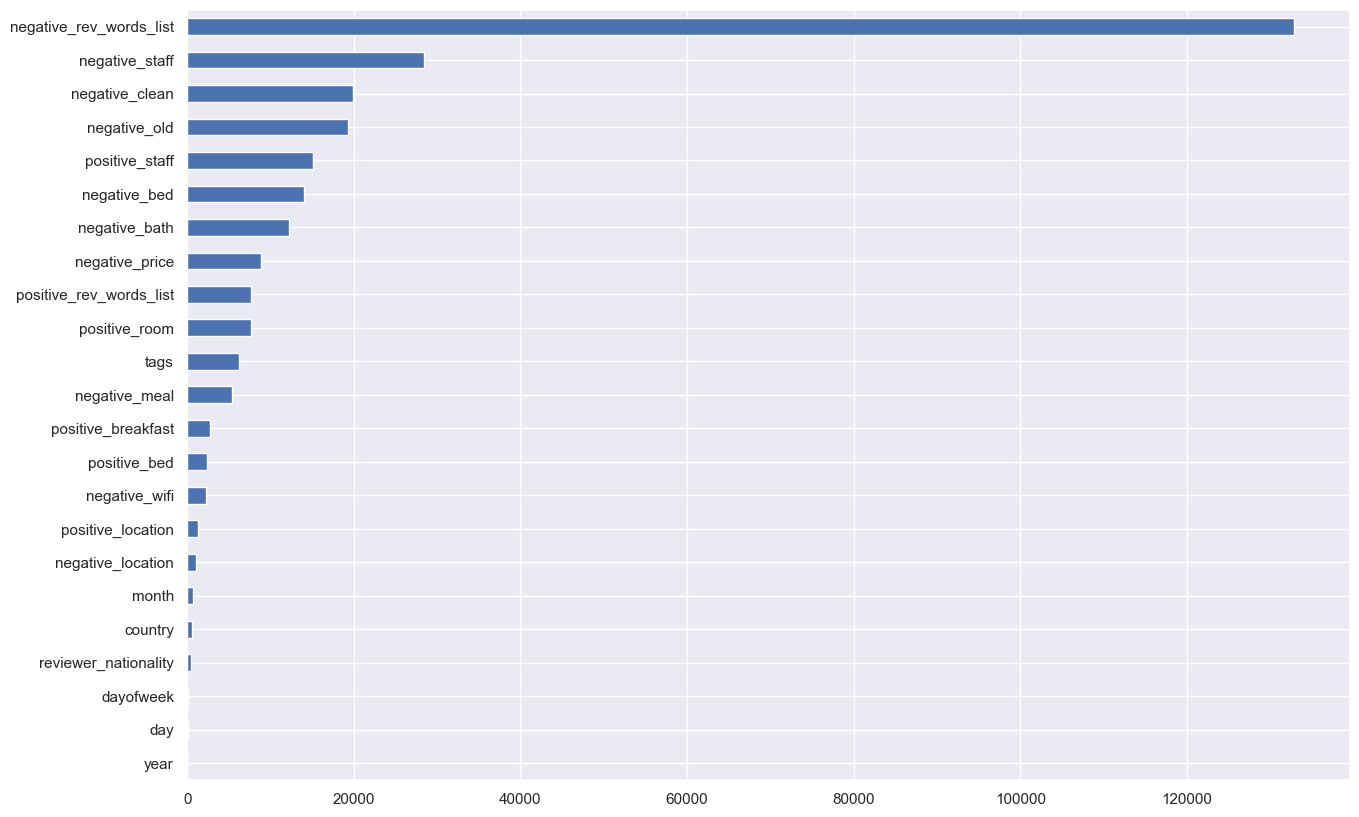

In [76]:
y=y.astype('int')

#Посмотрим на влияние категориальных признаков
from sklearn.feature_selection import chi2 # хи-квадрат

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [77]:
# Оставим категориальные признаки с рейтингом 250 и более
res_cols = ['reviewer_score']
res_cols.extend(imp_cat[imp_cat >= 250].index)
res_cols

['reviewer_score',
 'reviewer_nationality',
 'country',
 'month',
 'negative_location',
 'positive_location',
 'negative_wifi',
 'positive_bed',
 'positive_breakfast',
 'negative_meal',
 'tags',
 'positive_room',
 'positive_rev_words_list',
 'negative_price',
 'negative_bath',
 'negative_bed',
 'positive_staff',
 'negative_old',
 'negative_clean',
 'negative_staff',
 'negative_rev_words_list']

C:\Users\German\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<AxesSubplot: >

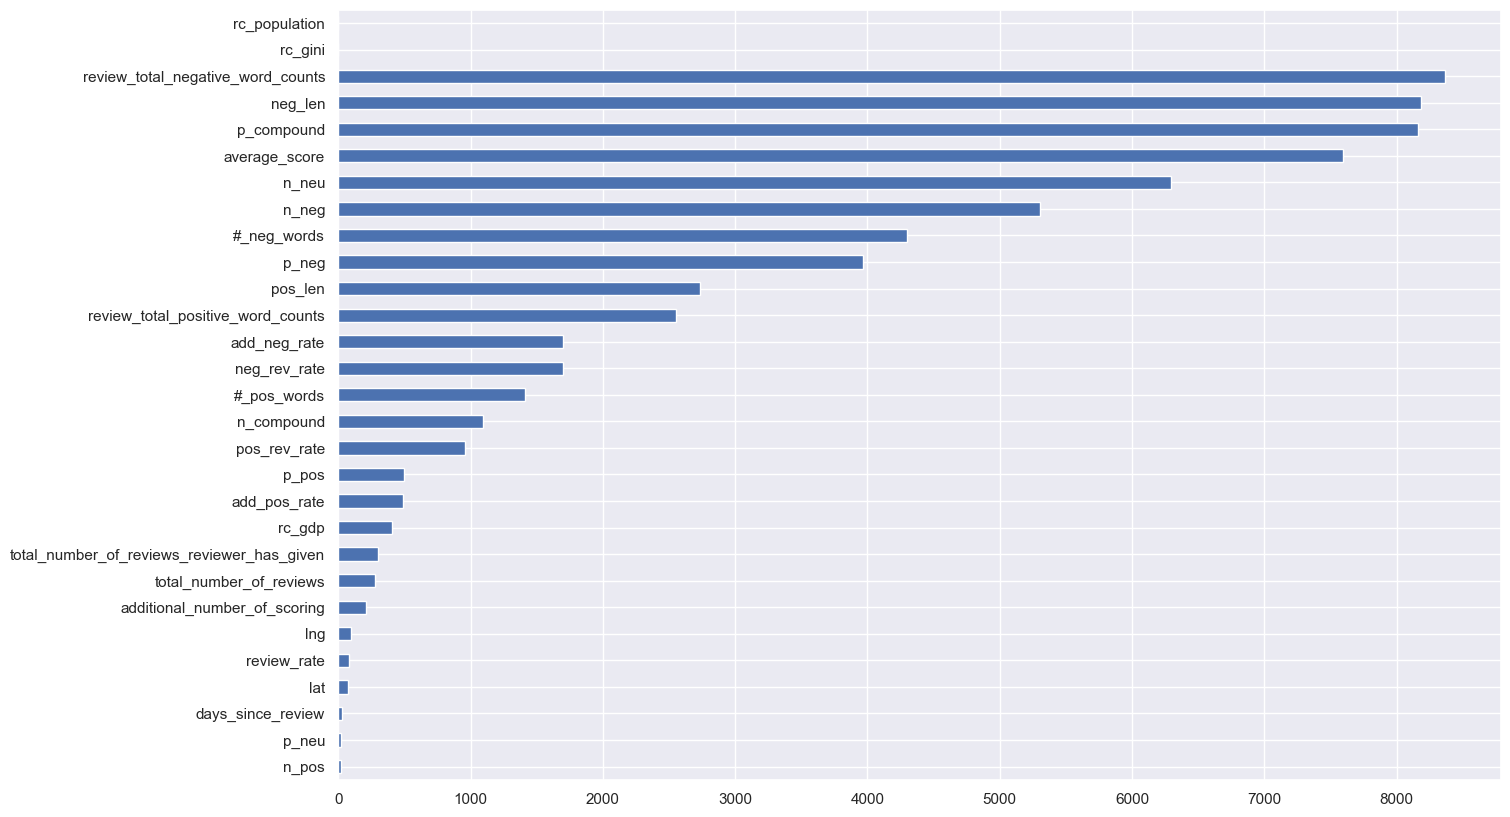

In [78]:
from sklearn.feature_selection import f_classif # anova

#Посмотрим на влияние числовых признаков
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [79]:
# Оставим числовые признаки с рейтингом 250 и более
res_cols.extend(imp_num[imp_num > 250].index)

res_cols

['reviewer_score',
 'reviewer_nationality',
 'country',
 'month',
 'negative_location',
 'positive_location',
 'negative_wifi',
 'positive_bed',
 'positive_breakfast',
 'negative_meal',
 'tags',
 'positive_room',
 'positive_rev_words_list',
 'negative_price',
 'negative_bath',
 'negative_bed',
 'positive_staff',
 'negative_old',
 'negative_clean',
 'negative_staff',
 'negative_rev_words_list',
 'total_number_of_reviews',
 'total_number_of_reviews_reviewer_has_given',
 'rc_gdp',
 'add_pos_rate',
 'p_pos',
 'pos_rev_rate',
 'n_compound',
 '#_pos_words',
 'neg_rev_rate',
 'add_neg_rate',
 'review_total_positive_word_counts',
 'pos_len',
 'p_neg',
 '#_neg_words',
 'n_neg',
 'n_neu',
 'average_score',
 'p_compound',
 'neg_len',
 'review_total_negative_word_counts']

In [80]:
# Преобразуем данные перед обучением модели
train_data = train_data[res_cols]
res_cols.remove('reviewer_score')
test_data = test_data[res_cols]

## 2.5 Анализ мультиколлинеарности и отбор признаков

CPU times: total: 547 ms
Wall time: 1.41 s


<AxesSubplot: >

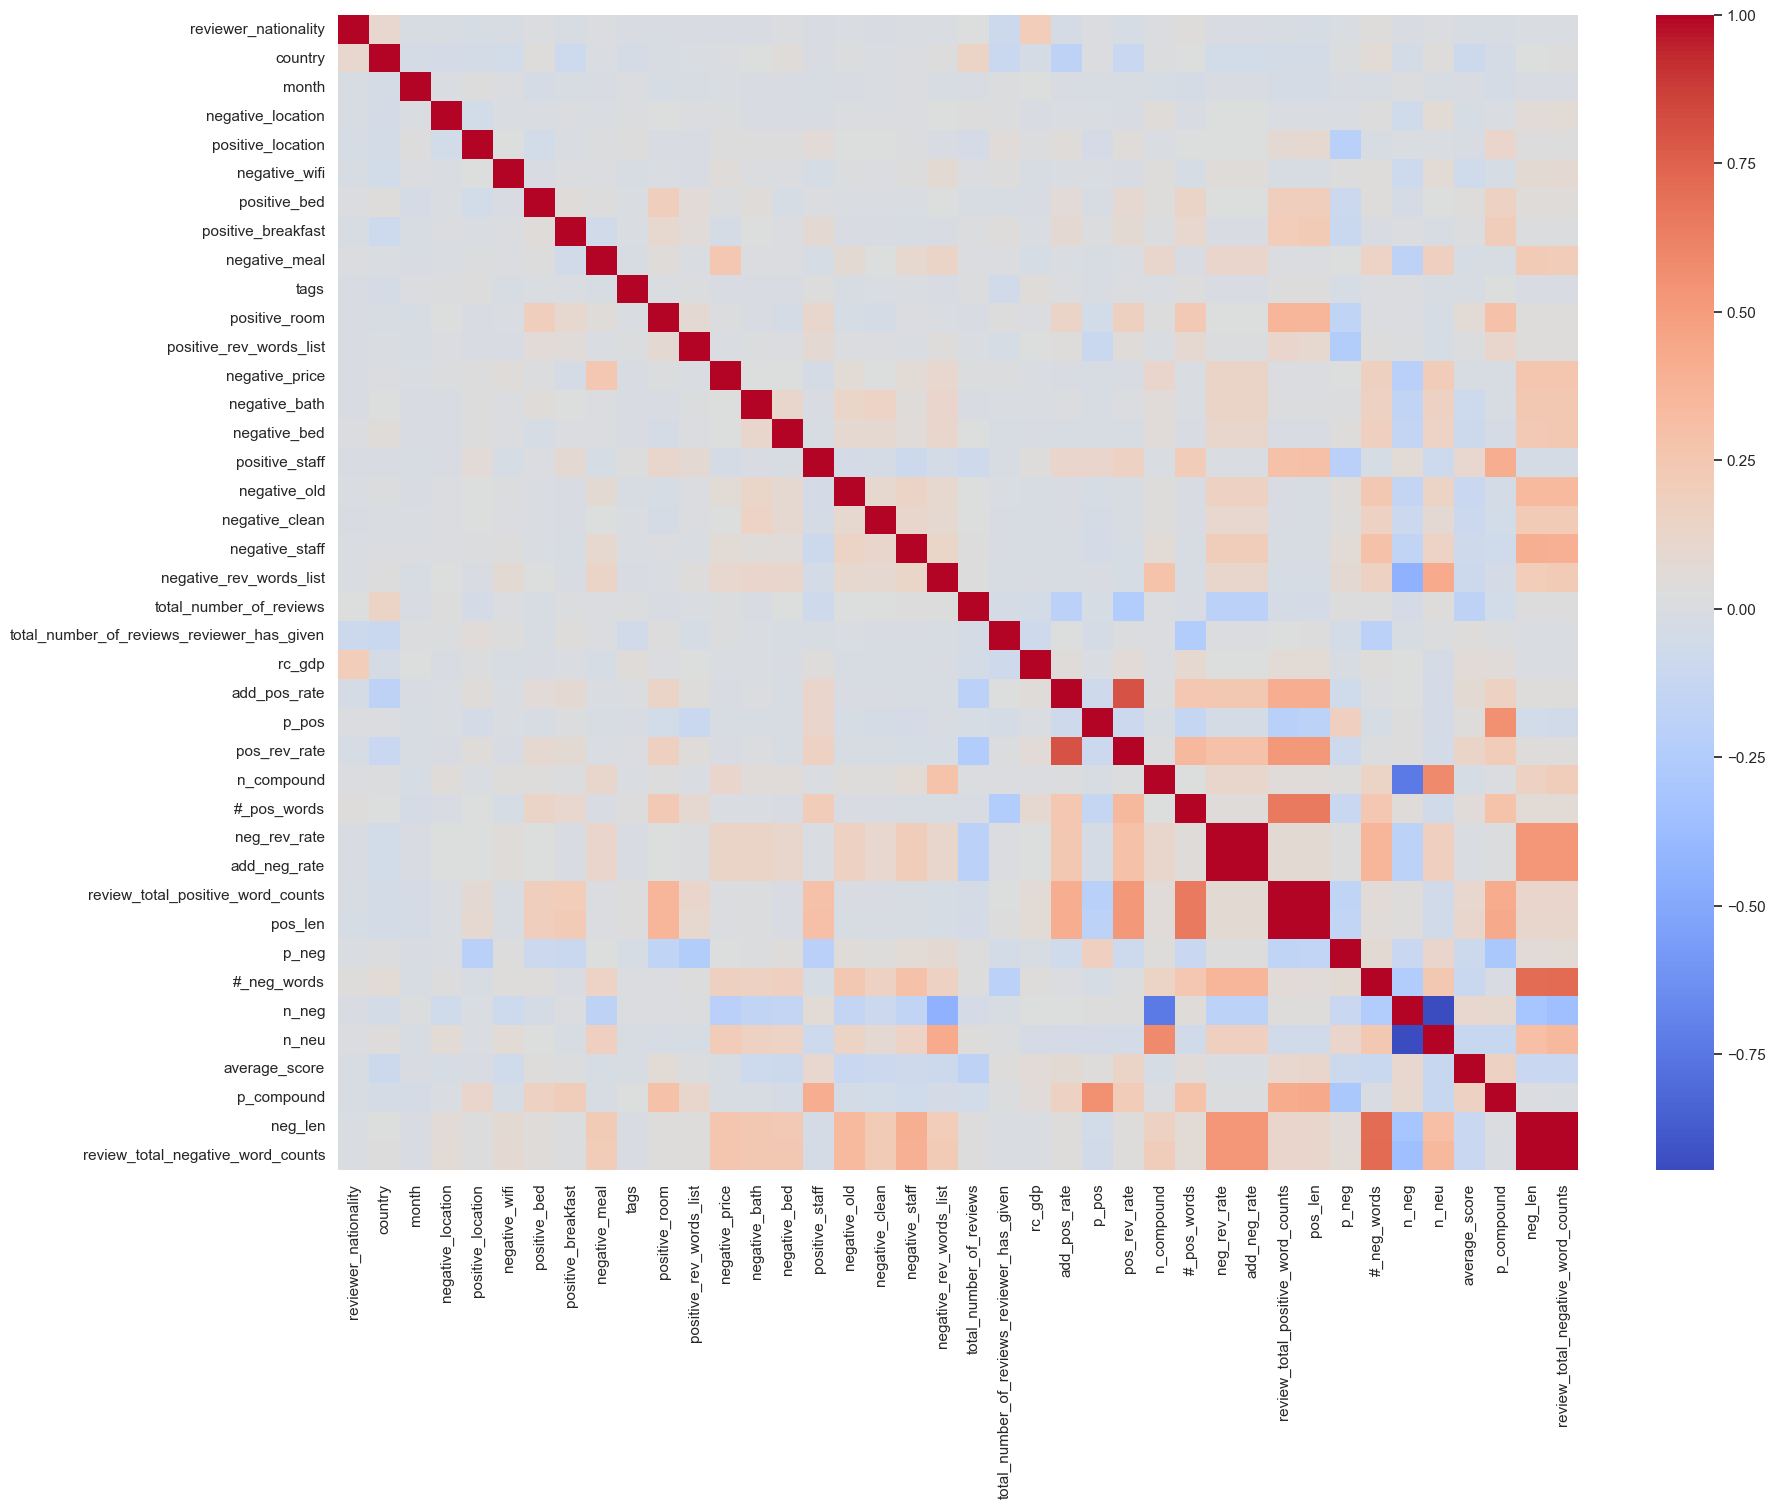

In [82]:
%%time

# Посмотрим на корреляцию оставшихся признаков
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(train_data.drop('reviewer_score',axis=1).corr(), cmap='coolwarm')

In [83]:
# Уберем признаки с мультиколлинеарностью
drop_col = ['neg_rev_rate','review_total_positive_word_counts','n_neg','neg_len','add_pos_rate', 'p_compound']

train_data.drop(drop_col,axis=1,inplace=True)
test_data.drop(drop_col,axis=1,inplace=True)

CPU times: total: 188 ms
Wall time: 1.07 s


<AxesSubplot: >

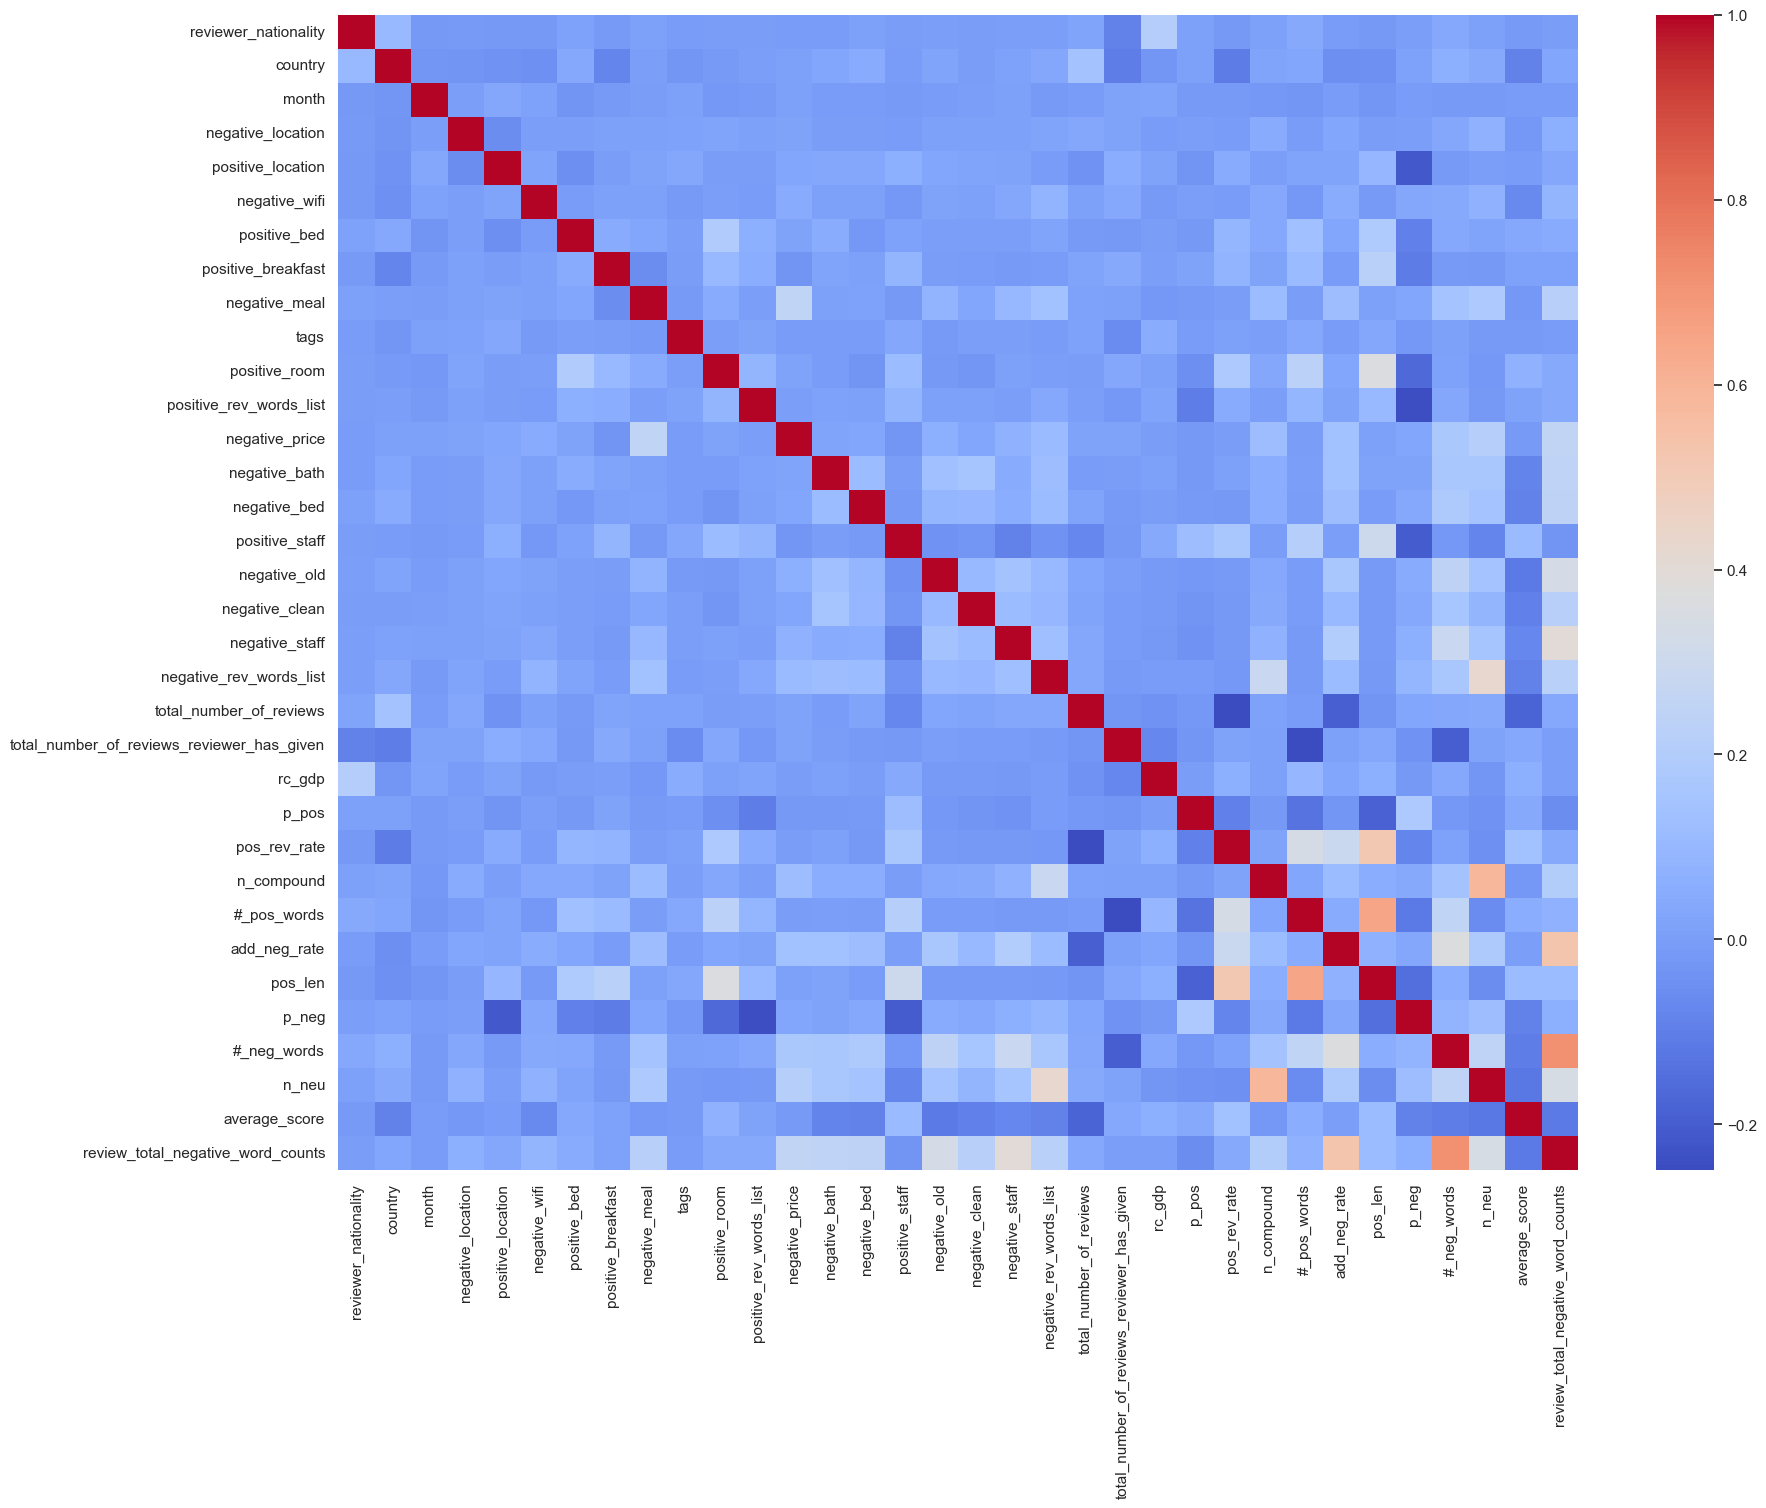

In [84]:
%%time

# Посмотрим на корреляцию оставшихся признаков
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(train_data.drop('reviewer_score',axis=1).corr(), cmap='coolwarm')

## 3. Обучение модели

In [85]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score']

In [86]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [87]:
%%time

# Создаём модель  
regr = RandomForestRegressor(n_estimators=500, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)  
      
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    4.4s


CPU times: total: 39min 31s
Wall time: 7min 18s


[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    5.0s finished


In [88]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12114936490466093


In [89]:
# Сделаем предсказание для тестовых данных
test_pred = regr.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    7.0s


Prediction for te_data:
[8.7524 7.6604 8.8626 ... 8.251  9.5496 6.9314]
Shape = (128935,)


[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    7.9s finished


In [95]:
# Сохраним реультаты в файл
submission['reviewer_score'] = test_pred
submission.to_csv('data/forest_rpedict_mape.csv', index = False)